# 核心能力提升班商业智能方向 004期 Week 11

### Thinking 1: 什么是Graph Embedding，都有哪些算法模型

Graph Embedding 能从图结构中提取节点和边的向量表示，这些向量表示能够包含原有网络结构和信息的隐含特性。  
主要方法有：
* factorization methods （图因式分解机）
* random walk techniques（随机游走）
* deep learning（深度学习）
有DeepWork算法、Node2Vec算法、图神经网络（GNN）模型等。

### Thinking 2: 如何使用Graph Embedding在推荐系统，比如NetFlix 电影推荐，请说明简要的思路

在推荐系统中如NetFlix电影推荐中，有用户之间的关系、（商品）电影之间的关系以及用户（商品）电影之间的关系，都适用于建模为图结构，然后通过Graph Embedding提取用户和商品的表示向量，再将这些向量应用在如评分预测等任务上，通过预测用户对电影的评分，对用户进行推荐。

### Thinking 3: 数据探索EDA都有哪些常用的方法和工具

1. 缺失值处理：   
    <b>pandas.DataFrame()</b>  
    df.isnull()        #表级判断是否为空（若为空返回True）  
    df.isnull().any()  #列级判断是否为空  
    df.isnull().sum()  #列级空值统计  
    df.fillna(df.mean(),inplace=True) # 均值补空值  
2. 重复值处理：  
    df.nunique()   #查看每一列数据有多少种（去重）（不包括空值）  
    df.unique()   #去重数据
3. 相关性：  
    df.corr()            #相关系数矩阵  
    <b>seaborn</b>   
    sns.heatmap()        #热力图做相关系数矩阵的可视化  
4. 可视化：  
    <b>matplotlib</b>  
    plt.plot()  
    plt.bar()  

### Action 1: seealsology是个针对Wikipidea页面的语义分析工具，可以找到与指定页面相关的Wikipidea
seealsology-data.tsv 文件存储了Wikipidea页面的关系（Source, Target, Depth）  
使用Graph Embedding对节点（Wikipidea）进行Embedding（DeepWalk或Node2Vec模型）  
对Embedding进行可视化（使用PCA呈现在二维平面上）  
找到和critical illness insurance相关的页面  

### 随机游走方法

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
# from graphembedding.ge.models import DeepWalk
import random
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/seealsology-data.tsv', sep='\t')
G = nx.from_pandas_edgelist(df, 'source', 'target', edge_attr=True, create_using=nx.Graph())

In [3]:
""" 
随机游走
input: 将节点和被遍历的路径的长度作为输入
output: 返回遍历节点的顺序:
"""
def get_randomwalk(node, path_length):
    random_walk = [node]
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break
        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node        
    return random_walk

In [4]:
all_nodes = list(G.nodes())
# 捕获数据集中所有节点的随机游走序列
random_walks = []
for n in tqdm(all_nodes):
    # 每个节点游走5次，每次最长距离为10
    for i in range(5):
        random_walks.append(get_randomwalk(n,10))

100%|███████████████████████████████████████████████████████████████████████████| 2399/2399 [00:00<00:00, 17166.10it/s]


In [5]:
# 训练skip-gram (word2vec)模型
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # 负采样
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

In [6]:
# 从random_walks中创建词汇表
model.build_vocab(random_walks, progress_per=2)
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)
model

In [7]:
# 输出和critical illness insurance相关的页面
print(model.similar_by_word('critical illness insurance'))

[('total permanent disability insurance', 0.9679026007652283), ('return of premium life insurance', 0.9192744493484497), ('anicom', 0.910193920135498), ('pet insurance', 0.8876873850822449), ('tontine', 0.879870593547821), ("servicemembers' group life insurance", 0.8659054636955261), ('prescription analytics', 0.858908474445343), ('internal revenue code section 79', 0.8453160524368286), ('rand health insurance experiment', 0.8350671529769897), ('health advocate', 0.8319866061210632)]


In [8]:
# 在二维空间中绘制所选节点的向量
def plot_nodes(word_list):
    # 每个节点的embedding为100维
    X = model[word_list]
    #print(type(X))
    # 将100维向量减少到2维
    pca = PCA(n_components=2)
    result = pca.fit_transform(X) 
    #print(result)
    # 绘制节点向量
    plt.figure(figsize=(12,9))
    # 创建一个散点图的投影
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    plt.show()

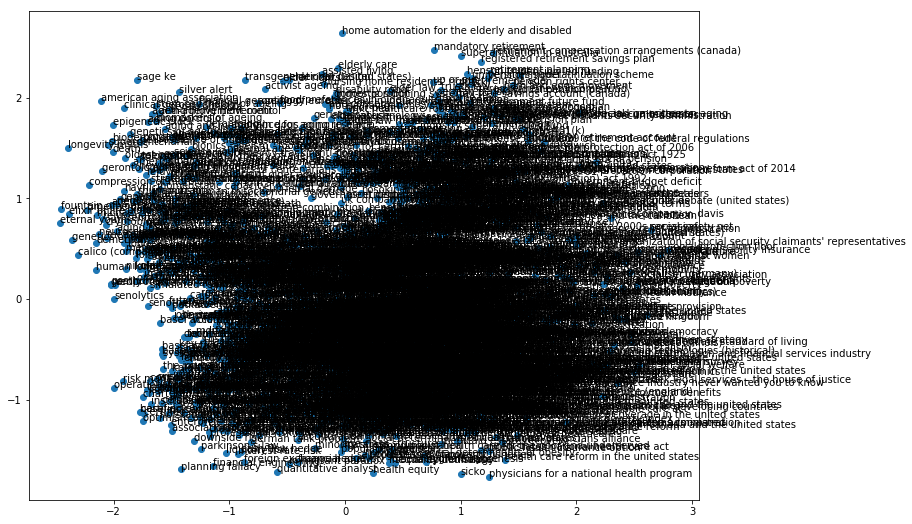

In [9]:
# 将所有的节点embedding进行绘制
plot_nodes(model.wv.vocab)

### Node2Vec方法

In [10]:
from node2vec import Node2Vec

In [11]:
# 初始化Node2Vec模型
model = Node2Vec(G, walk_length = 10, num_walks = 5, p = 0.25, q = 4, workers = 1)

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]


In [12]:
# 模型训练
result = model.fit(window=4, iter=20)

In [13]:
# 输出和critical illness insurance相关的页面
print(result.wv.most_similar('critical illness insurance'))

[('total permanent disability insurance', 0.9906502962112427), ('life insurance', 0.879996657371521), ('internal revenue code section 79', 0.8742575645446777), ("servicemembers' group life insurance", 0.8586434721946716), ('return of premium life insurance', 0.8531975150108337), ('self-funded health care', 0.8185446858406067), ('tontine', 0.8185015916824341), ('family income benefit insurance', 0.8168014287948608), ('history of insurance', 0.8167692422866821), ('pet insurance', 0.8078274726867676)]


In [14]:
# 得到节点的embedding
embeddings = result.wv
print(embeddings)

In [15]:
# 在二维空间中绘制所选节点的向量
def plot_nodes(word_list):
    # 每个节点的embedding为100维
    X = []
    for item in word_list:
        X.append(embeddings[item])
    #print(X.shape)
    # 将100维向量减少到2维
    pca = PCA(n_components=2)
    result = pca.fit_transform(X) 
    #print(result)
    # 绘制节点向量
    plt.figure(figsize=(12,9))
    # 创建一个散点图的投影
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(list(word_list)):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))        
    plt.show()

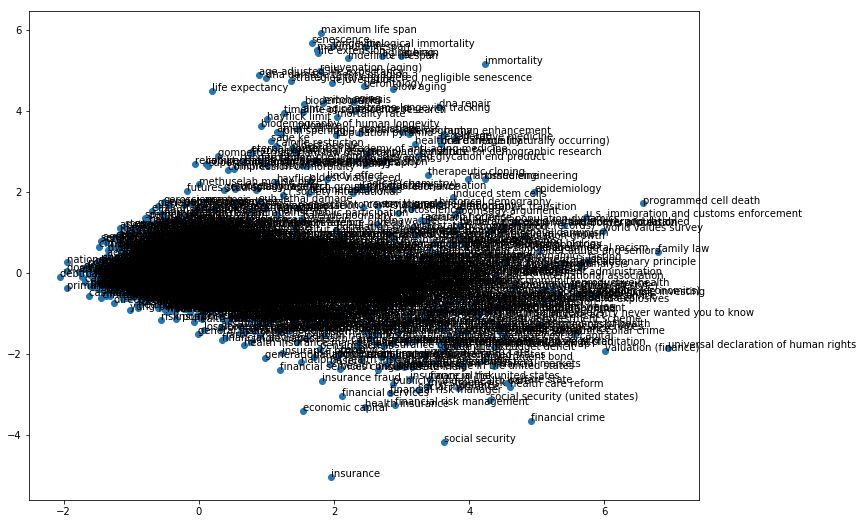

In [16]:
# 将所有的节点embedding进行绘制
plot_nodes(result.wv.vocab)

### Action 2: 二手车价格预测
数据集：
used_car_train_20200313.csv  
used_car_testA_20200313.csv  
数据来自某交易平台的二手车交易记录  
ToDo：给你一辆车的各个属性（除了price字段），预测它的价格  

In [17]:
# 数据加载
train_data = pd.read_csv('data/used_car/used_car_train_20200313.csv', sep=' ')
train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [18]:
test_data = pd.read_csv('data/used_car/used_car_testB_20200421.csv', sep=' ')
test_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,200000,133777,20000501,67.0,0,1.0,0.0,0.0,101,15.0,...,0.236520,0.000241,0.105319,0.046233,0.094522,3.619512,-0.280607,-2.019761,0.978828,0.803322
1,200001,61206,19950211,19.0,6,2.0,0.0,0.0,73,6.0,...,0.261518,0.000000,0.120323,0.046784,0.035385,2.997376,-1.406705,-1.020884,-1.349990,-0.200542
2,200002,67829,20090606,5.0,5,4.0,0.0,0.0,120,5.0,...,0.261691,0.090836,0.000000,0.079655,0.073586,-3.951084,-0.433467,0.918964,1.634604,1.027173
3,200003,8892,20020601,22.0,9,1.0,0.0,0.0,58,15.0,...,0.236050,0.101777,0.098950,0.026830,0.096614,-2.846788,2.800267,-2.524610,1.076819,0.461610
4,200004,76998,20030301,46.0,6,0.0,NaN,0.0,116,15.0,...,0.257000,0.000000,0.066732,0.057771,0.068852,2.839010,-1.659801,-0.924142,0.199423,0.451014


In [19]:
# 将regDate 转换为汽车注册时间（即时间diff）
dates = pd.to_datetime(train_data['regDate'], format='%Y%m%d', errors='coerce')
min_date = pd.to_datetime('19910101', format='%Y%m%d')

train_data['regTime'] = (dates - min_date).dt.days
test_data['regTime'] = (pd.to_datetime(train_data['regDate'], format='%Y%m%d', errors='coerce') - min_date).dt.days
train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,regTime
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,4840.0
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,4442.0
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,4841.0
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,2077.0
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,7672.0


In [20]:
# 将createDate转换为汽车售卖时间（即时间diff）
train_data['creatTime'] = (pd.to_datetime(train_data['creatDate'], format='%Y%m%d', errors='coerce') - min_date).dt.days
test_data['creatTime'] = (pd.to_datetime(test_data['creatDate'], format='%Y%m%d', errors='coerce') - min_date).dt.days
train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,regTime,creatTime
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,4840.0,9225
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,4442.0,9199
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,4841.0,9223
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,2077.0,9202
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,7672.0,9203


In [21]:
# 汽车使用时间 
train_data['usedTime'] = train_data['creatTime'] - train_data['regTime']
test_data['usedTime'] = test_data['creatTime'] - test_data['regTime']
train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_8,v_9,v_10,v_11,v_12,v_13,v_14,regTime,creatTime,usedTime
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,4840.0,9225,4385.0
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,4442.0,9199,4757.0
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,4841.0,9223,4382.0
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,2077.0,9202,7125.0
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,7672.0,9203,1531.0


In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 34 columns):
SaleID               150000 non-null int64
name                 150000 non-null int64
regDate              150000 non-null int64
model                149999 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    150000 non-null object
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null int64
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64
v_4       

In [23]:
# - 说明以后缺失值
train_data['notRepairedDamage'].value_counts()

0.0    111361
-       24324
1.0     14315
Name: notRepairedDamage, dtype: int64

In [24]:
#修改异常数据
train_data['power'][train_data['power']>600]=600
test_data['power'][test_data['power']>600]=600

In [25]:
# 众数补全
train_data['notRepairedDamage'].replace('-', '0.0', inplace=True)
train_data['notRepairedDamage'] = train_data['notRepairedDamage'].astype('float64')
test_data['notRepairedDamage'].replace('-', '0.0', inplace=True)
test_data['notRepairedDamage'] = test_data['notRepairedDamage'].astype('float64')
train_data.info()
train_data['notRepairedDamage'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 34 columns):
SaleID               150000 non-null int64
name                 150000 non-null int64
regDate              150000 non-null int64
model                149999 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    150000 non-null float64
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null int64
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64
v_4      

0.0    135685
1.0     14315
Name: notRepairedDamage, dtype: int64

In [26]:
# 查看数据缺失值
train_data.isnull().sum()

SaleID                   0
name                     0
regDate                  0
model                    1
brand                    0
bodyType              4506
fuelType              8680
gearbox               5981
power                    0
kilometer                0
notRepairedDamage        0
regionCode               0
seller                   0
offerType                0
creatDate                0
price                    0
v_0                      0
v_1                      0
v_2                      0
v_3                      0
v_4                      0
v_5                      0
v_6                      0
v_7                      0
v_8                      0
v_9                      0
v_10                     0
v_11                     0
v_12                     0
v_13                     0
v_14                     0
regTime              11347
creatTime                0
usedTime             11347
dtype: int64

In [27]:
# 训练集大小
train_data.shape

(150000, 34)

In [28]:
# 测试集大小
test_data.shape

(50000, 33)

In [29]:
# 找到数值类型的特征
numerical_cols = train_data.select_dtypes(exclude='object').columns
numerical_cols

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14', 'regTime', 'creatTime', 'usedTime'],
      dtype='object')

In [30]:
feature_cols = [col for col in numerical_cols if col not in ['SaleID','name','price', 'seller']]
feature_cols

['regDate',
 'model',
 'brand',
 'bodyType',
 'fuelType',
 'gearbox',
 'power',
 'kilometer',
 'notRepairedDamage',
 'regionCode',
 'offerType',
 'creatDate',
 'v_0',
 'v_1',
 'v_2',
 'v_3',
 'v_4',
 'v_5',
 'v_6',
 'v_7',
 'v_8',
 'v_9',
 'v_10',
 'v_11',
 'v_12',
 'v_13',
 'v_14',
 'regTime',
 'creatTime',
 'usedTime']

In [31]:
# 提取特征列
X_data = train_data[feature_cols]
Y_data = train_data['price']
X_test = test_data[feature_cols]

In [32]:
# 定义统计函数，方便了解数据分布
def show_stats(data):
    print('min :', np.min(data))
    print('max :', np.max(data))
    print('ptp :', np.ptp(data))
    print('mean:', np.mean(data))
    print('std :', np.std(data))
    print('var :', np.var(data))

In [33]:
print('训练集 Price的统计情况')
show_stats(Y_data)

训练集 Price的统计情况
min : 11
max : 99999
ptp : 99988
mean: 5923.327333333334
std : 7501.973469876438
var : 56279605.94272992


In [34]:
# 协方差
train_data.corr()['price']

SaleID              -0.001043
name                 0.002030
regDate              0.611959
model                0.136983
brand               -0.043799
bodyType             0.241303
fuelType             0.200536
gearbox              0.329075
power                0.556400
kilometer           -0.440519
notRepairedDamage   -0.157523
regionCode           0.014036
seller              -0.002004
offerType                 NaN
creatDate            0.002955
price                1.000000
v_0                  0.628397
v_1                  0.060914
v_2                  0.085322
v_3                 -0.730946
v_4                 -0.147085
v_5                  0.164317
v_6                  0.068970
v_7                 -0.053024
v_8                  0.685798
v_9                 -0.206205
v_10                -0.246175
v_11                -0.275320
v_12                 0.692823
v_13                -0.013993
v_14                 0.035911
regTime              0.610593
creatTime            0.016916
usedTime  

In [35]:
# 缺失值补全
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)

## xgboost预测

In [36]:
# 模型参数选择及验证
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
## xgb-Model
model_xgb = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #,objective ='reg:squarederror'

scores_train = []
scores = []

## 5折交叉验证方式
sk = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,val_ind in sk.split(X_data,Y_data):
    
    train_x = X_data.iloc[train_ind]
    train_y = Y_data.iloc[train_ind]
    val_x = X_data.iloc[val_ind]
    val_y = Y_data.iloc[val_ind]
    
    model_xgb.fit(train_x,train_y)
    pred_train_xgb = model_xgb.predict(train_x)
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    
    pred_xgb = model_xgb.predict(val_x)  
    score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)

print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))

Train mae: 533.0099467244925
Val mae 618.7895318133329


In [37]:
# 模型预测
model_xgb.fit(X_data, Y_data)
pred_y = model_xgb.predict(X_test)
print('XGBoost 预测结果的统计情况')
show_stats(pred_y)

XGBoost 预测结果的统计情况
min : -519.45355
max : 94011.1
ptp : 94530.555
mean: 6089.0283
std : 7740.194
var : 59910604.0


In [38]:
# 输出结果
result = pd.DataFrame()
result['SaleID'] = test_data['SaleID']
result['price'] = pred_y
result[result['price'] < 11]['price'] = 11
result.to_csv('./result_xgb.csv', index=False)

## 使用神经网络进行预测

In [39]:
import tensorflow

In [40]:
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [41]:
X = np.array(X_data)
y = np.array(Y_data).reshape(-1,1)
X_ = np.array(X_test)
X.shape, y.shape, X_.shape

((150000, 30), (150000, 1), (50000, 30))

In [42]:
# 数据规范化
ss = MinMaxScaler()
X = ss.fit_transform(X)
X_ = ss.transform(X_)

In [43]:
#切分数据集
x_train,x_test,y_train,y_test = train_test_split(X, y,test_size = 0.2)

In [59]:
model = keras.Sequential([
        keras.layers.BatchNormalization(),
        keras.layers.Dense(250,activation='relu',input_shape=[X.shape[1]]), 
        keras.layers.Dense(250,activation='relu'), 
        keras.layers.Dense(250,activation='relu'), 
        keras.layers.Dense(1)])
model.compile(loss='mean_absolute_error', optimizer='Adam')

In [64]:
model.fit(x_train,y_train,batch_size = 2048,epochs=350)

Epoch 1/350
120000/120000 [==============================] - ETA: 1s - loss: 466.497 - ETA: 0s - loss: 453.959 - ETA: 0s - loss: 463.708 - ETA: 0s - loss: 460.567 - ETA: 0s - loss: 462.532 - 0s 2us/step - loss: 463.1039
Epoch 2/350
120000/120000 [==============================] - ETA: 0s - loss: 480.009 - ETA: 0s - loss: 469.535 - ETA: 0s - loss: 465.007 - ETA: 0s - loss: 463.696 - ETA: 0s - loss: 464.281 - 0s 2us/step - loss: 463.6390
Epoch 3/350
120000/120000 [==============================] - ETA: 0s - loss: 466.734 - ETA: 0s - loss: 460.876 - ETA: 0s - loss: 458.042 - ETA: 0s - loss: 457.094 - ETA: 0s - loss: 458.624 - 0s 2us/step - loss: 459.7748
Epoch 4/350
120000/120000 [==============================] - ETA: 0s - loss: 429.970 - ETA: 0s - loss: 461.887 - ETA: 0s - loss: 459.589 - ETA: 0s - loss: 456.306 - ETA: 0s - loss: 458.360 - 0s 2us/step - loss: 459.8120
Epoch 5/350
120000/120000 [==============================] - ETA: 0s - loss: 456.367 - ETA: 0s - loss: 468.793 - ETA: 0s

In [65]:
#比较训练集和测试集效果
mean_absolute_error(y_train,model.predict(x_train))

430.7145240184665

In [66]:
mean_absolute_error(y_test,model.predict(x_test))

467.5901900300185

In [67]:
#输出结果预测
y_=model.predict(X_)
show_stats(y_)
data_test_price = pd.DataFrame(y_,columns = ['price'])
results = pd.concat([test_data['SaleID'],data_test_price],axis = 1)
results.to_csv('results_MLP.csv',sep = ',',index = None)

min : -5.862035
max : 106842.43
ptp : 106848.29
mean: 5871.8916
std : 7366.305
var : 54262452.0
